In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,\
    Rescaling, RandomFlip, RandomRotation, RandomZoom, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input,\
    decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array,\
    ImageDataGenerator
from tensorflow.keras import Model, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.model_selection import train_test_split
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import keras_tuner as kt
from tqdm import tqdm

In [2]:
# Je me positionne dans mon répertoire de travail personnel
os.chdir("C:\\Users\\Julien Gremillot\\OneDrive\\Documents\\" +
         "OpenClassrooms\\github\\OpenClassrooms_Ingenieur_M" +
         "achine_Learning\Classez des images à l'aide d'algo" +
         "rithmes de Deep Learning")

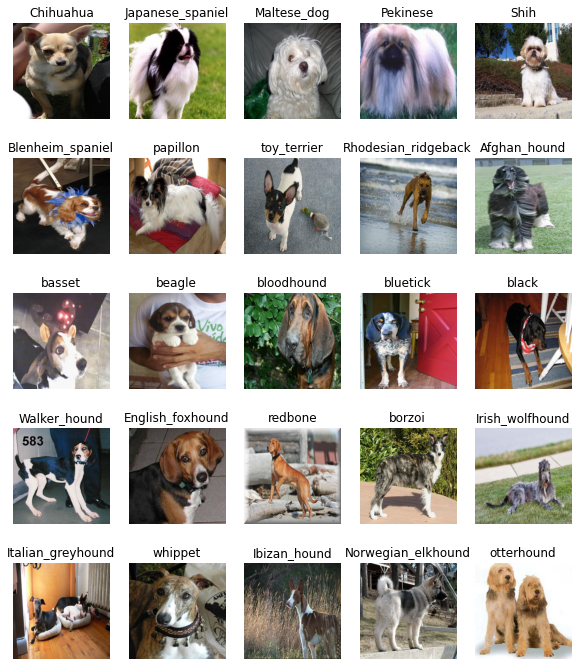

In [3]:
# Lecture des images du dataset
dataset_dir = "./images/"
images = np.array([])
races = np.array([])   
width, height = 224, 224
plt.figure(figsize=(10,12))
i = 1
for sub_dir in os.listdir(dataset_dir):
    sub_dir_images = os.listdir(dataset_dir + sub_dir)
    race = sub_dir.split('-')[1]
    j = 0
    for sub_dir_image in sub_dir_images:
        image = os.path.join(dataset_dir, sub_dir, sub_dir_image)
        images = np.append(images, image)
        races = np.append(races, race)
        if i <= 25 and j == 0:
            img = Image.open(image) 
            img_resized = img.resize((width, height))
            plt.subplot(5, 5, i)
            plt.axis('off')
            plt.title(race)
            plt.imshow(img_resized)
            i = i + 1
            j = j + 1
plt.show()

In [4]:
images

array(['./images/n02085620-Chihuahua\\n02085620_10074.jpg',
       './images/n02085620-Chihuahua\\n02085620_10131.jpg',
       './images/n02085620-Chihuahua\\n02085620_10621.jpg', ...,
       './images/n02116738-African_hunting_dog\\n02116738_9829.jpg',
       './images/n02116738-African_hunting_dog\\n02116738_9844.jpg',
       './images/n02116738-African_hunting_dog\\n02116738_9924.jpg'],
      dtype='<U69')

In [5]:
races

array(['Chihuahua', 'Chihuahua', 'Chihuahua', ..., 'African_hunting_dog',
       'African_hunting_dog', 'African_hunting_dog'], dtype='<U32')

In [6]:
print(images.shape)
print(races.shape)

(20580,)
(20580,)


In [7]:
tf.__version__

'2.7.0'

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(
#    images, races, test_size=0.2, random_state=11)

In [19]:
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(height, width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [20]:
class_names = train_ds.class_names
print(class_names)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(height, width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [22]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [23]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
print(len(class_names))

120


In [31]:
model = Sequential()  # Création d'un réseau de neurones vide 

#model.add(Rescaling(1./255, input_shape=(height, width, 3))),
    
# Ajout de la première couche de convolution, suivie d'une couche ReLU
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), padding='same',
                 activation='relu'))

# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))

# Ajout de la première couche de pooling
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
model.add(Dense(128, activation='relu'))

# Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
model.add(Dense(64, activation='relu'))

# Ajout de la dernière couche fully-connected qui permet de classifier
model.add(Dense(len(class_names), activation='softmax'))

In [27]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
# OPTION
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 401408)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               51380352  
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                      

In [34]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


C:\anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


515/515 [==============================] - 1118s 2s/step - loss: 31.0563 - accuracy: 0.0100 - val_loss: 4.7846 - val_accuracy: 0.0112
Epoch 2/10
515/515 [==============================] - 1019s 2s/step - loss: 4.7076 - accuracy: 0.0265 - val_loss: 4.8242 - val_accuracy: 0.0143
Epoch 3/10
515/515 [==============================] - 1010s 2s/step - loss: 4.0995 - accuracy: 0.1405 - val_loss: 5.3094 - val_accuracy: 0.0172
Epoch 4/10
515/515 [==============================] - 1023s 2s/step - loss: 2.6969 - accuracy: 0.4277 - val_loss: 6.9559 - val_accuracy: 0.0180
Epoch 5/10
515/515 [==============================] - 1125s 2s/step - loss: 1.4533 - accuracy: 0.7099 - val_loss: 9.5746 - val_accuracy: 0.0197
Epoch 6/10
515/515 [==============================] - 1155s 2s/step - loss: 0.8204 - accuracy: 0.8508 - val_loss: 12.4843 - val_accuracy: 0.0214
Epoch 7/10
515/515 [==============================] - 1365s 3s/step - loss: 0.5314 - accuracy: 0.9072 - val_loss: 13.6143 - val_accuracy: 0.0199


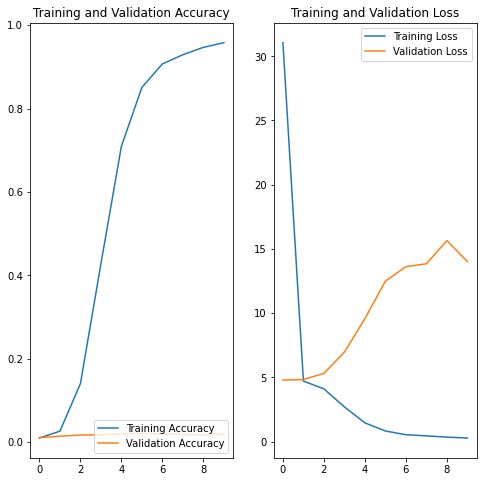

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape=(height, width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

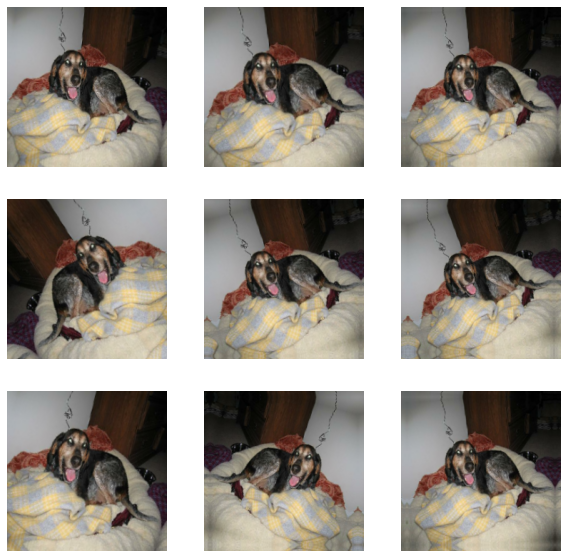

In [40]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Pour éviter l'overfit, on ajoute une couche de "Dropout"

In [44]:
model = Sequential([
  data_augmentation,
  Rescaling(1./255),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(class_names))
])

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
515/515 [==============================] - 636s 1s/step - loss: 4.7470 - accuracy: 0.0161 - val_loss: 4.6184 - val_accuracy: 0.0197
Epoch 2/15
515/515 [==============================] - 637s 1s/step - loss: 4.4905 - accuracy: 0.0323 - val_loss: 4.3691 - val_accuracy: 0.0418
Epoch 3/15
515/515 [==============================] - 644s 1s/step - loss: 4.2929 - accuracy: 0.0488 - val_loss: 4.2488 - val_accuracy: 0.0571
Epoch 4/15
515/515 [==============================] - 686s 1s/step - loss: 4.1707 - accuracy: 0.0627 - val_loss: 4.1463 - val_accuracy: 0.0690
Epoch 5/15
515/515 [==============================] - 603s 1s/step - loss: 4.0675 - accuracy: 0.0821 - val_loss: 4.0492 - val_accuracy: 0.0828
Epoch 6/15
515/515 [==============================] - 577s 1s/step - loss: 3.9891 - accuracy: 0.0882 - val_loss: 3.9688 - val_accuracy: 0.0940
Epoch 7/15
515/515 [==============================] - 594s 1s/step - loss: 3.9094 - accuracy: 0.1044 - val_loss: 3.9268 - val_accuracy: 0.1001

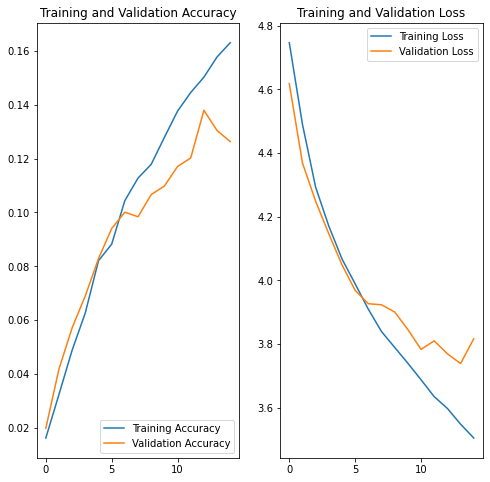

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/15
515/515 [==============================] - 476s 922ms/step - loss: 4.6819 - accuracy: 0.0166 - val_loss: 4.4695 - val_accuracy: 0.0260
Epoch 2/15
515/515 [==============================] - 467s 907ms/step - loss: 4.4034 - accuracy: 0.0335 - val_loss: 4.3391 - val_accuracy: 0.0435
Epoch 3/15
515/515 [==============================] - 452s 878ms/step - loss: 4.2498 - accuracy: 0.0553 - val_loss: 4.1704 - val_accuracy: 0.0586
Epoch 4/15
515/515 [==============================] - 443s 860ms/step - loss: 4.1058 - accuracy: 0.0678 - val_loss: 4.1117 - val_accuracy: 0.0671
Epoch 5/15
515/515 [==============================] - 439s 853ms/step - loss: 4.0029 - accuracy: 0.0796 - val_loss: 4.0167 - val_accuracy: 0.0831
Epoch 6/15
515/515 [==============================] - 437s 849ms/step - loss: 3.9289 - accuracy: 0.0967 - val_loss: 3.9982 - val_accuracy: 0.0826
Epoch 7/15
515/515 [==============================] - 436s 846ms/step - loss: 3.8486 - accuracy: 0.1078 - val_loss: 3.9087 -

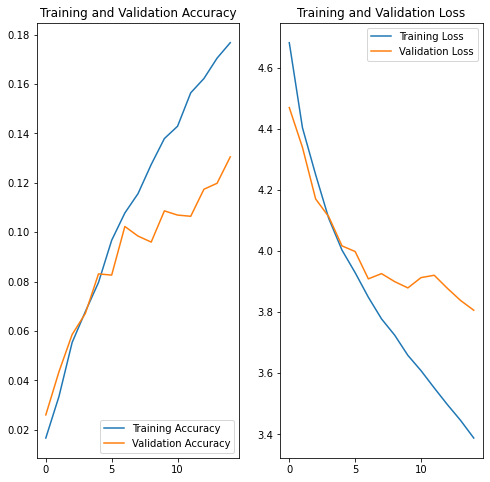

In [49]:
model = Sequential([
  data_augmentation,
  Rescaling(1./255),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(128, activation='relu'),  # ajout d'une 2e couche ici
  Dense(len(class_names))
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/15
515/515 [==============================] - 694s 1s/step - loss: 4.7863 - accuracy: 0.0122 - val_loss: 4.7576 - val_accuracy: 0.0114
Epoch 2/15
515/515 [==============================] - 691s 1s/step - loss: 4.5859 - accuracy: 0.0282 - val_loss: 4.4741 - val_accuracy: 0.0326
Epoch 3/15
515/515 [==============================] - 691s 1s/step - loss: 4.4206 - accuracy: 0.0419 - val_loss: 4.3656 - val_accuracy: 0.0445
Epoch 4/15
515/515 [==============================] - 686s 1s/step - loss: 4.3014 - accuracy: 0.0522 - val_loss: 4.2754 - val_accuracy: 0.0581
Epoch 5/15
515/515 [==============================] - 685s 1s/step - loss: 4.1748 - accuracy: 0.0705 - val_loss: 4.1816 - val_accuracy: 0.0734
Epoch 6/15
515/515 [==============================] - 686s 1s/step - loss: 4.0528 - accuracy: 0.0852 - val_loss: 4.0795 - val_accuracy: 0.0826
Epoch 7/15
515/515 [==============================] - 688s 1s/step - loss: 3.9427 - accuracy: 0.1022 - val_loss: 3.9923 - val_accuracy: 0.0899

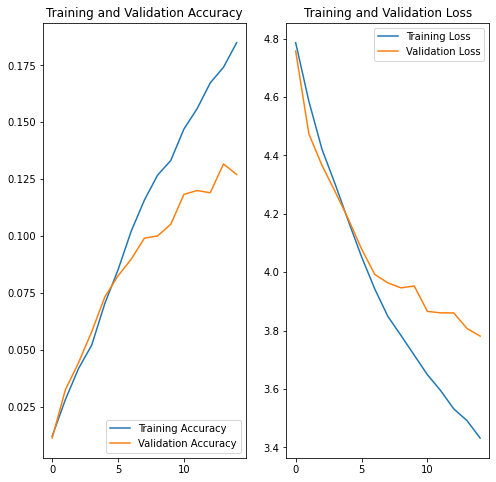

In [50]:
model = Sequential([
  data_augmentation,
  Rescaling(1./255),
  Conv2D(32, 3, padding='same', activation='relu'),  # 16 -> 32
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),  # 32 -> 64
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(class_names))
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Je fais de nouveaux tests de "data augmentation" avec ImageDataGenerator

In [9]:
image_data_generator = ImageDataGenerator(rescale=1./255,
                             featurewise_center=True,
                             zca_whitening=True,
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.2,
                             dtype=tf.float32)

In [12]:
train_generator = image_data_generator.flow_from_directory(
    dataset_dir,
    subset="training",
    seed=123,
    class_mode='sparse',
    target_size=(height, width), 
    color_mode='rgb',
    batch_size=batch_size)

Found 16508 images belonging to 120 classes.


In [13]:
validation_generator = image_data_generator.flow_from_directory(
    dataset_dir,
    subset="validation",
    seed=123,
    class_mode='sparse',
    target_size=(height, width), 
    color_mode='rgb',
    batch_size=batch_size)

Found 4072 images belonging to 120 classes.


<ipython-input-23-7ab358be4094>:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(  # ici fit_generator au lieu de fit
C:\anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/15
516/516 [==============================] - 1015s 2s/step - loss: 4.7881 - accuracy: 0.0120 - val_loss: 4.7498 - val_accuracy: 0.0199
Epoch 2/15
516/516 [==============================] - 963s 2s/step - loss: 4.6126 - accuracy: 0.0201 - val_loss: 4.5615 - val_accuracy: 0.0194
Epoch 3/15
516/516 [==============================] - 969s 2s/step - loss: 4.4997 - accuracy: 0.0296 - val_loss: 4.4803 - val_accuracy: 0.0371
Epoch 4/15
516/516 [==============================] - 848s 2s/step - loss: 4.3294 - accuracy: 0.0512 - val_loss: 4.3174 - val_accuracy: 0.0516
Epoch 5/15
516/516 [==============================] - 859s 2s/step - loss: 4.1280 - accuracy: 0.0744 - val_loss: 4.1947 - val_accuracy: 0.0643
Epoch 6/15
516/516 [==============================] - 799s 2s/step - loss: 3.9712 - accuracy: 0.0975 - val_loss: 4.1961 - val_accuracy: 0.0722
Epoch 7/15
516/516 [==============================] - 815s 2s/step - loss: 3.8192 - accuracy: 0.1229 - val_loss: 4.0909 - val_accuracy: 0.081

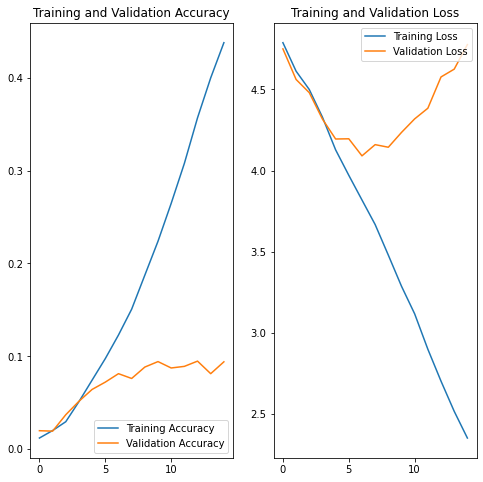

In [23]:
model = Sequential([
  Input(shape=(height, width, 3)),
  Conv2D(32, 3, padding='same', activation='relu'),  # 16 -> 32
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),  # 32 -> 64
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(class_names))
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 15
history = model.fit_generator(  # ici fit_generator au lieu de fit
  train_generator,  # ici l'objet issu de ImageDataGenerator
  validation_data=validation_generator,
  epochs=epochs
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Comme j'ai un UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators. Je recommence :

Epoch 1/15
516/516 [==============================] - 683s 1s/step - loss: 4.6664 - accuracy: 0.0181 - val_loss: 4.5520 - val_accuracy: 0.0243
Epoch 2/15
516/516 [==============================] - 683s 1s/step - loss: 4.4062 - accuracy: 0.0364 - val_loss: 4.3702 - val_accuracy: 0.0410
Epoch 3/15
516/516 [==============================] - 664s 1s/step - loss: 4.2899 - accuracy: 0.0522 - val_loss: 4.2969 - val_accuracy: 0.0440
Epoch 4/15
516/516 [==============================] - 660s 1s/step - loss: 4.1519 - accuracy: 0.0693 - val_loss: 4.1759 - val_accuracy: 0.0651
Epoch 5/15
516/516 [==============================] - 661s 1s/step - loss: 4.0021 - accuracy: 0.0909 - val_loss: 4.1341 - val_accuracy: 0.0759
Epoch 6/15
516/516 [==============================] - 659s 1s/step - loss: 3.8756 - accuracy: 0.1133 - val_loss: 4.0821 - val_accuracy: 0.0818
Epoch 7/15
516/516 [==============================] - 660s 1s/step - loss: 3.7632 - accuracy: 0.1289 - val_loss: 4.0843 - val_accuracy: 0.0808

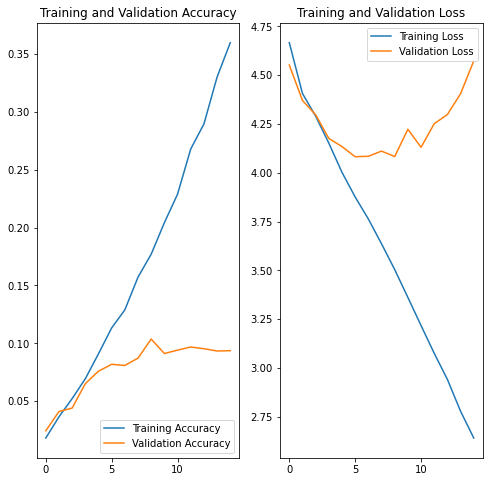

In [26]:
model = Sequential([
  Input(shape=(height, width, 3)),
  Conv2D(32, 3, padding='same', activation='relu'),  # 16 -> 32
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),  # 32 -> 64
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(class_names))
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 15
history = model.fit(
  train_generator,  # ici l'objet issu de ImageDataGenerator
  validation_data=validation_generator,
  epochs=epochs
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

On essaie de mettre en place une optimisation des hyper-paramètres avec Keras Tuner

In [26]:
def model_builder(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(width, height, 3)))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dense(len(class_names)))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

In [31]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=os.path.normpath('C:/'),
                     project_name='dogs')

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

J'essaie de récupérer les infos depuis le train_ds mais c'est trop gros pour mon PC. Je me limite à 25% des données.

In [15]:
img_train = None
label_train = None
i = 0
for image_batch, labels_batch in tqdm(train_ds):
    if img_train == None:
        img_train = image_batch
        label_train = labels_batch
    else:
        img_train = tf.concat(axis=0, values = [img_train, image_batch])
        label_train = tf.concat(axis=0, values = [label_train, labels_batch])
    i = i + 1
    if i > (len(train_ds) * 0.25):
        break
print("img_train:", img_train.shape)
print("label_train:", label_train.shape)

 25%|███████████████████▉                                                            | 128/515 [01:03<03:12,  2.01it/s]

img_train: (4128, 224, 224, 3)
label_train: (4128,)


In [32]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 04m 27s]
val_accuracy: 0.013317191042006016

Best val_accuracy So Far: 0.014527845196425915
Total elapsed time: 00h 51m 32s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 352 and the optimal learning rate for the optimizer
is 0.01.

